In [5]:
# coding: utf-8
import sys, os
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
from common.layers import *
from common.gradient import numerical_gradient
from collections import OrderedDict

class SimpleConvNet:
    def __init__(self, input_dim=(1, 28, 28,3), 
                 conv_param={'filter_num':30, 'filter_size':5, 'pad':0, 'stride':1},
                 hidden_size=100, output_size=10, weight_init_std=0.01):
        filter_num = conv_param['filter_num']
        filter_size = conv_param['filter_size']
        filter_pad = conv_param['pad']
        filter_stride = conv_param['stride']
        input_size = input_dim[1]
        conv_output_size = (input_size - filter_size + 2*filter_pad) / filter_stride + 1
        pool_output_size = int(filter_num * (conv_output_size/2) * (conv_output_size/2))

        # 가중치 초기화
        self.params = {}
        self.params['W1'] = weight_init_std * \
                            np.random.randn(filter_num, input_dim[0], filter_size, filter_size)
        self.params['b1'] = np.zeros(filter_num)
        self.params['W2'] = weight_init_std * \
                            np.random.randn(pool_output_size, hidden_size)
        self.params['b2'] = np.zeros(hidden_size)
        self.params['W3'] = weight_init_std * \
                            np.random.randn(hidden_size, output_size)
        self.params['b3'] = np.zeros(output_size)

        # 계층 생성
        self.layers = OrderedDict()
        self.layers['Conv1'] = Convolution(self.params['W1'], self.params['b1'],
                                           conv_param['stride'], conv_param['pad'])
        self.layers['Relu1'] = Relu()
        self.layers['Pool1'] = Pooling(pool_h=2, pool_w=2, stride=2)
        self.layers['Affine1'] = Affine(self.params['W2'], self.params['b2'])
        self.layers['Relu2'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W3'], self.params['b3'])

        self.last_layer = SoftmaxWithLoss()

    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)

        return x

    def loss(self, x, t):
        y = self.predict(x)
        return self.last_layer.forward(y, t)

    def accuracy(self, x, t, batch_size=100):
        if t.ndim != 1 : t = np.argmax(t, axis=1)
        
        acc = 0.0
        
        for i in range(int(x.shape[0] / batch_size)):
            tx = x[i*batch_size:(i+1)*batch_size]
            tt = t[i*batch_size:(i+1)*batch_size]
            y = self.predict(tx)
            y = np.argmax(y, axis=1)
            acc += np.sum(y == tt) 
        
        return acc / x.shape[0]

    def gradient(self, x, t):
        # forward
        self.loss(x, t)

        # backward
        dout = 1
        dout = self.last_layer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 결과 저장
        grads = {}
        grads['W1'], grads['b1'] = self.layers['Conv1'].dW, self.layers['Conv1'].db
        grads['W2'], grads['b2'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grads['W3'], grads['b3'] = self.layers['Affine2'].dW, self.layers['Affine2'].db

        return grads

In [6]:
# coding: utf-8
import sys, os
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
from common.optimizer import *

class Trainer:
    def __init__(self, network, x_train, t_train, x_test, t_test,
                 epochs=20, mini_batch_size=100,
                 optimizer='SGD', optimizer_param={'lr':0.01}, 
                 evaluate_sample_num_per_epoch=None, verbose=True):
        self.network = network
        self.verbose = verbose
        self.x_train = x_train
        self.t_train = t_train
        self.x_test = x_test
        self.t_test = t_test
        self.epochs = epochs
        self.batch_size = mini_batch_size
        self.evaluate_sample_num_per_epoch = evaluate_sample_num_per_epoch

        # optimzer
        optimizer_class_dict = {'sgd':SGD, 'momentum':Momentum, 'nesterov':Nesterov,
                                'adagrad':AdaGrad, 'rmsprpo':RMSprop, 'adam':Adam}
        self.optimizer = optimizer_class_dict[optimizer.lower()](**optimizer_param)
        
        self.train_size = x_train.shape[0] #60000
        self.iter_per_epoch = max(self.train_size / mini_batch_size, 1) #600
        self.max_iter = int(epochs * self.iter_per_epoch) #12000
        self.current_iter = 0
        self.current_epoch = 0
        
        self.train_loss_list = []
        self.train_acc_list = []
        self.test_acc_list = []

    def train_step(self):
        batch_mask = np.random.choice(self.train_size, self.batch_size)
        x_batch = self.x_train[batch_mask]
        t_batch = self.t_train[batch_mask]
        
        grads = self.network.gradient(x_batch, t_batch)
        self.optimizer.update(self.network.params, grads)
        
        loss = self.network.loss(x_batch, t_batch)
        self.train_loss_list.append(loss)
        
        if self.current_iter % self.iter_per_epoch == 0: #currnet_iter가 600의 배수일 때 마다
            self.current_epoch += 1
            
            x_train_sample, t_train_sample = self.x_train, self.t_train
            x_test_sample, t_test_sample = self.x_test, self.t_test
            if not self.evaluate_sample_num_per_epoch is None:
                t = self.evaluate_sample_num_per_epoch
                x_train_sample, t_train_sample = self.x_train[:t], self.t_train[:t]
                x_test_sample, t_test_sample = self.x_test[:t], self.t_test[:t]
                
            train_acc = self.network.accuracy(x_train_sample, t_train_sample)
            test_acc = self.network.accuracy(x_test_sample, t_test_sample)
            self.train_acc_list.append(train_acc)
            self.test_acc_list.append(test_acc)

            if self.verbose: print("=== epoch:" + str(self.current_epoch) + ", train acc:" + str(train_acc) + ", test acc:" + str(test_acc) + " ===")
            
        if self.current_iter % (self.iter_per_epoch / 10) == 0: #currnet_iter가 60의 배수일 때 마다 
            print("train loss:" + str(loss))
        self.current_iter += 1

    def train(self):
        for i in range(self.max_iter):
            self.train_step()

        train_acc = self.network.accuracy(self.x_train, self.t_train)
        test_acc = self.network.accuracy(self.x_test, self.t_test)

        if self.verbose:
            print("=============== Final Test Accuracy ===============")
            print("train acc:" + str(train_acc) + ", test acc:" + str(test_acc))

In [7]:
from dataset.fashion.mnist import load_mnist
(x_train, t_train), (x_test, t_test) = load_mnist(flatten=False)

# 시간이 오래 걸릴 경우 데이터를 줄인다.
# x_train, t_train = x_train[:20000], t_train[:20000]
# x_test, t_test = x_test[:4000], t_test[:4000]

#x_train = x_train.astype('float32') / 255.0
#x_test = x_test.astype('float32') / 255.0

max_epochs = 20

network = SimpleConvNet(input_dim=(1,28,28), 
                        conv_param = {'filter_num': 30, 'filter_size': 5, 'pad': 0, 'stride': 1},
                        hidden_size=100, output_size=10, weight_init_std=0.01)
                        
trainer = Trainer(network, x_train, t_train, x_test, t_test,
                  epochs=max_epochs, mini_batch_size=100,
                  optimizer='Adam', optimizer_param={'lr': 0.001},
                  evaluate_sample_num_per_epoch=1000)
trainer.train()

=== epoch:1, train acc:0.297, test acc:0.304 ===
train loss:2.299340195199625
train loss:0.7769801161988612
train loss:0.6490245326116514
train loss:0.5516208745245575
train loss:0.5808442966223214
train loss:0.5401200563414588
train loss:0.45947914817292357
train loss:0.49064324281505306
train loss:0.3443652116244328
train loss:0.4858347185771489
=== epoch:2, train acc:0.839, test acc:0.831 ===
train loss:0.4327722538690077
train loss:0.3950424853749322
train loss:0.34727147311987094
train loss:0.5087062280515714
train loss:0.3338741714545914
train loss:0.32702742472381024
train loss:0.392601536400386
train loss:0.3552432898320222
train loss:0.39307046900365245
train loss:0.4392537587369514
=== epoch:3, train acc:0.882, test acc:0.866 ===
train loss:0.32886804164336103
train loss:0.1826912526990833
train loss:0.3074099705579632
train loss:0.2823304506747953
train loss:0.2809914494871587
train loss:0.2733115310529879
train loss:0.2621302807909968
train loss:0.2776536340134215
train los

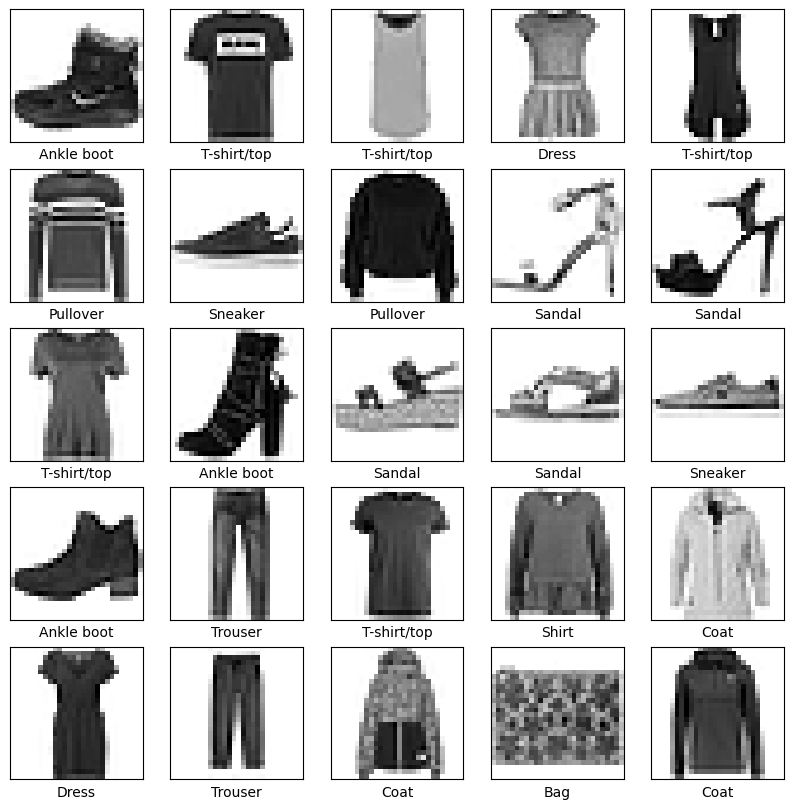

In [10]:
import matplotlib.pyplot as plt

def sample_imgs(x, y, class_names):
    plt.figure(figsize=(10, 10))
    for i in range(25):
        plt.subplot(5, 5, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(x[i].reshape(28, 28), cmap=plt.cm.binary)
        plt.xlabel(class_names[y[i]])
    plt.show()

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

sample_imgs(x_train, t_train, class_names)

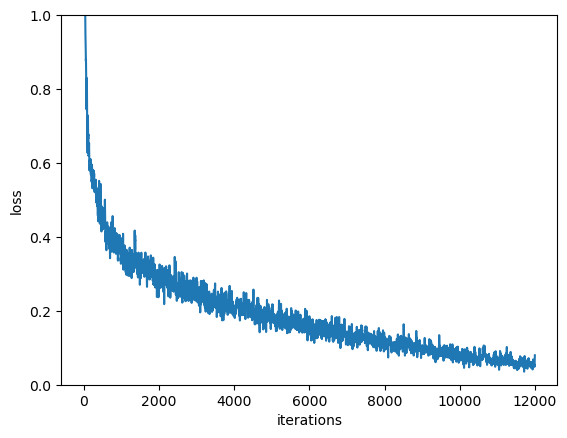

In [9]:
import matplotlib.pyplot as plt
from common.util import smooth_curve

max_iterations = len(trainer.train_loss_list)
x = np.arange(max_iterations)

plt.plot(x, smooth_curve(trainer.train_loss_list))
plt.xlabel("iterations")
plt.ylabel("loss")
plt.ylim(0, 1)
plt.show()